Overview
--------

Extracting building footprints from LiDAR derived elevation models, NAIP, and thematic mask layers.


Input Data
----------

The thematic data include a subset of roads, hydroline, and hydropoly datasets for Jefferson county WV and Washington county MD.

The input LAZ file in sample data is in UTM zone 18 N.  The derivatative DSM, DTM, and DEM were created with the commands outlined below the `lidar-processing` utility should handle point filtering but currently lacks that functionality.  `las2las` was obtained from a homebrewed install of libLAS.  The input LiDAR data has already been de-noised.

Surface models generated from LiDAR have different names depending on who you ask so for the sake of this exercis they are defined as follows:

1. Digital Surface Model (DSM) - Gridded first return
2. Digital Terrain Model (DTM) - Gridded last return
3. Digital Elevation Model (DEM) - Gridded ground returns/classification

A Normalized Digital Terrain Model is DTM - DEM, which leaves roughly absolute height above ground for the remaining pixels and eliminates most vegetation.  It is immediately clipped to > 3m in order to eliminate ground pixel noise and any building we really care about is at least 3 meters tall.
    
    # DTM
    las2las --last-return-only \
        -i sample-data/VA-WV-MD_FEMA_Region3_UTM18_2012_000842.laz \
        -o sample-data/last.las
    ./lidar-processing.py \
        sample-data/last.las \
        sample-data/DTM.tif \
        -tr 1 1 \
        -co COMPRESS=DEFLATE -co TILED=YES -co PREDICTOR=3 -co ZLEVEL=9 \
        -crs EPSG:32618 \
        --interpolation nearest

    # DEM
    las2las --keep-classes 2 \
        -i sample-data/VA-WV-MD_FEMA_Region3_UTM18_2012_000842.laz \
        -o sample-data/ground.las
    ./lidar-processing.py \
        sample-data/ground.las \
        sample-data/DEM.tif \
        -tr 1 1 \
        -co COMPRESS=DEFLATE -co TILED=YES -co PREDICTOR=3 -co ZLEVEL=9 \
        -crs EPSG:32618 \
        --interpolation nearest
        
    # DSM - not needed for this exercise
    las2las --first-return-only \
        -i sample-data/VA-WV-MD_FEMA_Region3_UTM18_2012_000842.laz \
        -o sample-data/first.las
    ./lidar-processing.py \
        sample-data/first.las \
        sample-data/DSM.tif \
        -tr 1 1 \
        -co COMPRESS=DEFLATE -co TILED=YES -co PREDICTOR=3 -co ZLEVEL=9 \
        -crs EPSG:32618 \
        --interpolation nearest
        

###Imports

In [19]:
%matplotlib inline
import os
import fiona
from matplotlib import pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import asShape

###Identify all the needed files, make sure they exist

Cache the DTM raster's metadata so we can extract information from it later.

In [48]:
dtm_path = 'sample-data/DTM.tif'
dem_path = 'sample-data/DEM.tif'
mask_path = 'sample-data/thematic-mask.tif'
naip_path = 'sample-data/NAIP.tif'

# Keys are paths and vals are buffer distances
thematic_mask_paths = {
    'sample-data/tl_2014_24043_areawater.geojson': 0,
    'sample-data/tl_2014_24_prisecroads.geojson': 3,
    'sample-data/tl_2014_54037_areawater.geojson': 0,
    'sample-data/tl_2014_54037_linearwater.geojson': 1,
    'sample-data/tl_2014_54037_roads.geojson': 3
}

# Define some additional commonly used variables
with rasterio.open(dtm_path) as src:
    dtm_meta = src.meta.copy()
    dtm_shape = src.shape
    dtm_nodata = src.meta['nodata']
    dtm_dtype = src.meta['dtype']
    dtm_affine = src.meta['affine']
    dtm_bounds = src.bounds
    dtm_x_min, dtm_y_min, dtm_x_max, dtm_y_max = dtm_bounds

###Create a mask layer from the thematic datasets

A mask layer would be created here on the fly but I kept encountering issues with
driver clashes between fiona and rasterio and a crashing python kernel.  Instead the mask was built a mask like this:

```
# Buffer the necessary datasources
$ fio cat sample-data/tl_2014_24_prisecroads.geojson \
    | ./streaming-topology-operations.py -to buffer:distance=4 \
    | fio load sample-data/buffered/tl_2014_24_prisecroads.geojson \
        -f GeoJSON --sequence --src_crs EPSG:32618 --dst_crs EPSG:32618
$ fio cat sample-data/tl_2014_54037_linearwater.geojson \
    | ./streaming-topology-operations.py -to buffer:distance=1 \
    | fio load sample-data/buffered/tl_2014_54037_linearwater.geojson \
        -f GeoJSON --sequence --src_crs EPSG:32618 --dst_crs EPSG:32618
$ fio cat sample-data/tl_2014_54037_roads.geojson \
    | ./streaming-topology-operations.py -to buffer:distance=3 \
    | fio load sample-data/buffered/tl_2014_54037_roads.geojson \
        -f GeoJSON --sequence --src_crs EPSG:32618 --dst_crs EPSG:32618

# Get an empty version of the DSM to use as a field for rasterization
$ gdal_calc.py -A sample-data/DTM.tif \
    --calc="0" \
    --out=sample-data/thematic-mask.tif \
    --co=COMPRESS=LZW --co=ZLEVEL=9 \
    --co=TILED=YES --co=NBITS=1 --type=Byte 

$ gdal_rasterize -burn 1 \
    sample-data/tl_2014_24043_areawater.geojson \
    sample-data/thematic-mask.tif 
$ gdal_rasterize -burn 1 \
    sample-data/tl_2014_54037_areawater.geojson \
    sample-data/thematic-mask.tif 
$ gdal_rasterize -burn 1 \
    sample-data/buffered/tl_2014_24_prisecroads.geojson \
    sample-data/thematic-mask.tif 
$ gdal_rasterize -burn 1 \
    sample-data/buffered/tl_2014_54037_linearwater.geojson \
    sample-data/thematic-mask.tif 
$ gdal_rasterize -burn 1 \
    sample-data/buffered/tl_2014_54037_roads.geojson \
    sample-data/thematic-mask.tif
```

# mask_layer = np.full(dtm_shape, 0, dtm_dtype)
# for mask_path, buff_dist in thematic_mask_paths.items():
#     with fiona.open(mask_path) as src:
#         mask_layer = rasterize(
#             shapes=[asShape(f['geometry']).buffer(buff_dist) for f in src],
#             out_shape=mask_layer.shape,
#             fill=1,
#             out=mask_layer,
#             transform=dtm_affine,
#             all_touched=True,
#             default_value=0,
#             dtype='uint8'
#         )

In [11]:
# Generate a Normalized DTM by subtracting the DEM from the DTM
with rasterio.open(dtm_path) as dtm, rasterio.open(dem_path) as dem:
    ndtm = dtm.read_band(1) - dem.read_band(1)

In [57]:
# Load the intersecting NAIP area
with rasterio.open(naip_path) as src:
    print(dtm_bounds)
    window = [~dtm_affine * pair for pair in ((dtm_y_max, dtm_x_min), (dtm_y_min, dtm_x_max))]
    print(window)
#     naip = src.read(window=window)

BoundingBox(left=258000.0, bottom=4368000.0, right=259500.0, top=4369500.0)
[(4111500.0, 4111500.0), (4110000.0, 4110000.0)]


###Display layers

Thematic mask


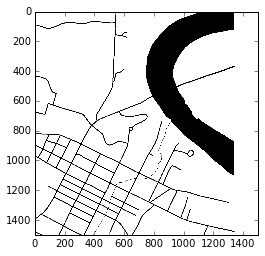

In [28]:
with rasterio.open(mask_path) as src:
    thematic_mask = src.read_band(1)

print("Thematic mask")
plt.imshow(thematic_mask)
plt.set_cmap('binary')
plt.show()

nDTM:


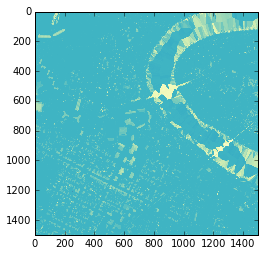

In [20]:
print("nDTM:")
plt.imshow(ndtm)
plt.set_cmap('YlGnBu_r')
plt.show()

DTM:


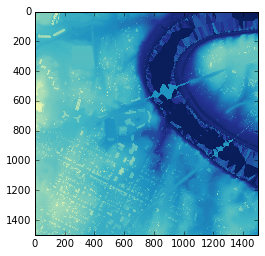

In [7]:
print("DTM:")
with rasterio.open(dtm_path) as dtm:
    plt.imshow(dtm.read_band(1))
    plt.set_cmap('YlGnBu_r')
    plt.show()

DEM:


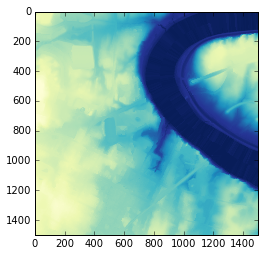

In [8]:
print("DEM:")
with rasterio.open(dem_path) as dem:
    plt.imshow(dem.read_band(1))
    plt.set_cmap('YlGnBu_r')
    plt.show()

NAIP


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


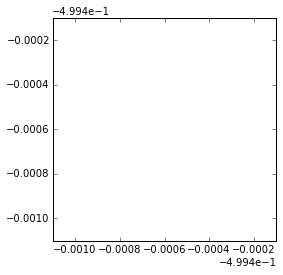

In [36]:
print("NAIP")
plt.imshow(np.transpose(naip, [1,2,0]))
plt.show()

In [30]:
masked_naip = np.ma.MaskedArray(naip, mask=thematic_mask)
masked_ndtm = np.ma.MaskedArray(ndtm, mask=thematic_mask)
plt.imshow(np.transpose(masked_naip, [1,2,0]))
plt.show()
plt.imshow(masked_ndtm)
plt.show()

MaskError: Mask and data not compatible: data size is 25345152, mask size is 2250000.